## Task
To build an incremental and personalized learner that separates spam from non-spam.

### Load emails

In [1]:
# Go to source root
import os
os.chdir('../src/')

In [2]:
from email_ingestion import EmailIngester

# Try different dataset 
ham_path = '../data/raw/ham/'
spam_path = '../data/raw/spam/'

spam_ratio = 0.5

ingester = EmailIngester(tokenize=False)  # No tokenization. Will use sklearn.
print("Ingesting ham..")
ham_data = ingester.ingest_folder(ham_path)

print("Ingesting spam..")
spam_data = ingester.ingest_folder(spam_path, max_files=spam_ratio*len(ham_data))

Ingesting ham..
Processed 19088 / 19088 emails (10.065s).
Ingesting spam..
Processed 9057 / 9544 emails (10.682s).


In [3]:
def add_label(data, is_spam=False):
    for record in data:
        record['is_spam'] = is_spam
        
add_label(ham_data, is_spam=False)
add_label(spam_data, is_spam=True)
email_data = ham_data + spam_data

In [4]:
def generate_text_dataset(emails):

    # Generate dataset
    X = []
    for email in emails:
        record = ''
        if email['subject'] is not None:
            record += email['subject'] + '\n'
        if 'body' in email:
            record += email['body']
        X.append(record)
        
    y = [email['is_spam'] for email in email_data]
    return X, y

X_raw, y = generate_text_dataset(email_data)

### Data splitting

In [5]:
# Warning: doing a random split while there is natural order in the data is dangerous.
from sklearn.model_selection import train_test_split

X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.33, random_state=42)    

### Feature generation


In [6]:
from sklearn.feature_extraction.text import HashingVectorizer

# Uses hashing trick to turn words into vectors.
# Independent of language and pre-existing corpus
vectorizer = HashingVectorizer(
    stop_words='english', non_negative=True,
    binary=True, n_features=2**16
)

X_train = vectorizer.transform(X_raw_train)
X_test = vectorizer.transform(X_raw_test)


### Benchmarks on many models


In [7]:
from time import time
from sklearn import metrics
from sklearn.utils.extmath import density as vector_density
 
from plotting.confusion_matrix import plot_confusion_matrix
%matplotlib inline
    
def benchmark(clf):
    print('_' * 80)

    clf_descr = str(clf).split('(')[0]
    
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time:   %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:    %0.3fs" % test_time)

    spam_score = metrics.recall_score(y_test, pred, pos_label=True)
    ham_score = metrics.recall_score(y_test, pred, pos_label=False)
    print("SPAM recall:  %0.3f" % spam_score)
    print("HAM recall:   %0.3f" % ham_score)
    print()

    if hasattr(clf, 'coef_'):
            print("dimensionality: %d" % clf.coef_.shape[1])
            print("density: %f" % vector_density(clf.coef_))

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=("HAM", "SPAM")))
    print()

    cm = metrics.confusion_matrix(y_test, pred, labels=(False, True))
    plot_confusion_matrix(cm, ("HAM", "SPAM"))
    print()
    
    return clf_descr, (spam_score, ham_score), train_time, test_time

***Random Forest***
________________________________________________________________________________
train time:   3.283s
test time:    0.066s
SPAM recall:  0.943
HAM recall:   0.989

classification report:
             precision    recall  f1-score   support

        HAM       0.97      0.99      0.98      6286
       SPAM       0.98      0.94      0.96      3002

avg / total       0.97      0.97      0.97      9288


Confusion matrix, without normalization


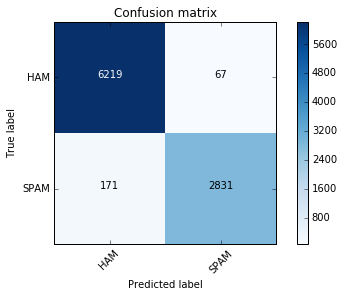


***Ridge Classifier***
________________________________________________________________________________
train time:   0.560s
test time:    0.004s
SPAM recall:  0.984
HAM recall:   0.993

dimensionality: 65536
density: 0.820099
classification report:
             precision    recall  f1-score   support

        HAM       0.99      0.99      0.99      6286
       SPAM       0.98      0.98      0.98      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


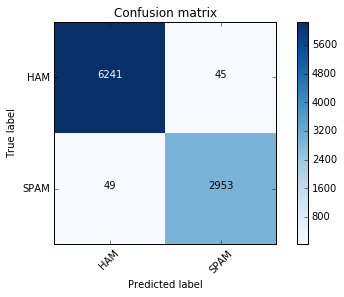


***Perceptron***
________________________________________________________________________________
train time:   0.290s
test time:    0.004s
SPAM recall:  0.984
HAM recall:   0.990

dimensionality: 65536
density: 0.267639
classification report:
             precision    recall  f1-score   support

        HAM       0.99      0.99      0.99      6286
       SPAM       0.98      0.98      0.98      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


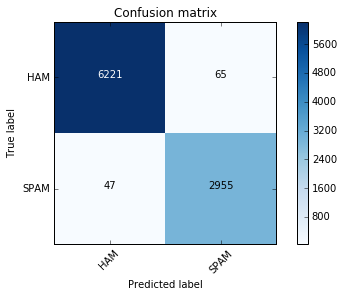


***L2 Reguralized SVM***
________________________________________________________________________________
train time:   0.311s
test time:    0.004s
SPAM recall:  0.993
HAM recall:   0.990

dimensionality: 65536
density: 0.820099
classification report:
             precision    recall  f1-score   support

        HAM       1.00      0.99      0.99      6286
       SPAM       0.98      0.99      0.99      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


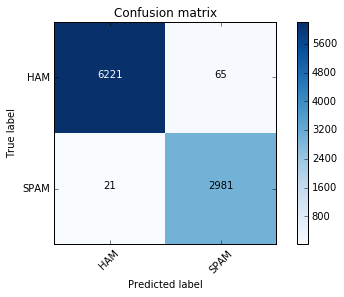


***L1 Reguralized SVM***
________________________________________________________________________________
train time:   0.338s
test time:    0.005s
SPAM recall:  0.993
HAM recall:   0.981

dimensionality: 65536
density: 0.013168
classification report:
             precision    recall  f1-score   support

        HAM       1.00      0.98      0.99      6286
       SPAM       0.96      0.99      0.98      3002

avg / total       0.99      0.98      0.98      9288


Confusion matrix, without normalization


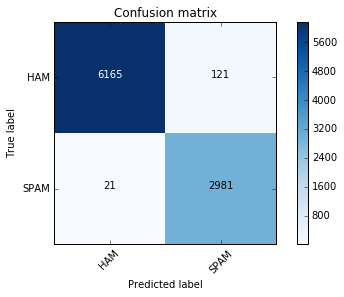


***L2 Reguralized SGD***
________________________________________________________________________________
train time:   0.282s
test time:    0.004s
SPAM recall:  0.993
HAM recall:   0.986

dimensionality: 65536
density: 0.588104
classification report:
             precision    recall  f1-score   support

        HAM       1.00      0.99      0.99      6286
       SPAM       0.97      0.99      0.98      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


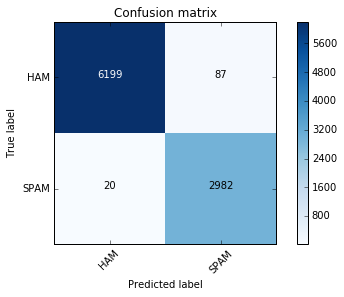


***L1 Reguralized SGD***
________________________________________________________________________________
train time:   0.876s
test time:    0.005s
SPAM recall:  0.990
HAM recall:   0.972

dimensionality: 65536
density: 0.006638
classification report:
             precision    recall  f1-score   support

        HAM       1.00      0.97      0.98      6286
       SPAM       0.95      0.99      0.97      3002

avg / total       0.98      0.98      0.98      9288


Confusion matrix, without normalization


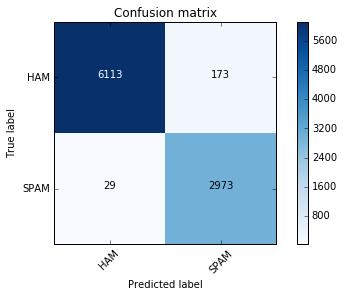


***Elastic-Net Reguralized SGD***
________________________________________________________________________________
train time:   1.201s
test time:    0.004s
SPAM recall:  0.994
HAM recall:   0.982

dimensionality: 65536
density: 0.081619
classification report:
             precision    recall  f1-score   support

        HAM       1.00      0.98      0.99      6286
       SPAM       0.96      0.99      0.98      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


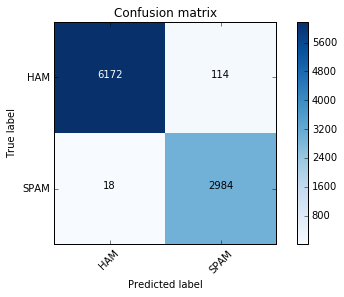


***Multinomial Naive Bayes***
________________________________________________________________________________
train time:   0.021s
test time:    0.007s
SPAM recall:  0.972
HAM recall:   0.993

dimensionality: 65536
density: 1.000000
classification report:
             precision    recall  f1-score   support

        HAM       0.99      0.99      0.99      6286
       SPAM       0.99      0.97      0.98      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


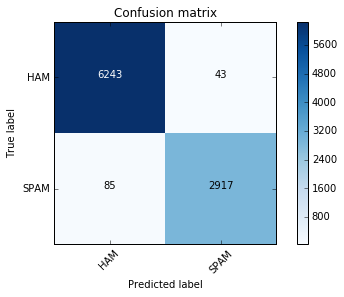


***Bernoulli Naive Bayes***
________________________________________________________________________________
train time:   0.038s
test time:    0.016s
SPAM recall:  0.975
HAM recall:   0.990

dimensionality: 65536
density: 1.000000
classification report:
             precision    recall  f1-score   support

        HAM       0.99      0.99      0.99      6286
       SPAM       0.98      0.98      0.98      3002

avg / total       0.98      0.98      0.98      9288


Confusion matrix, without normalization


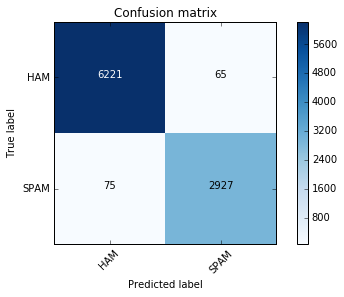


***Linear SVC Feature Selection + SVC***
________________________________________________________________________________


/Users/tomdr/VirtualEnvs/work-py3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tomdr/VirtualEnvs/work-py3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


train time:   0.466s
test time:    0.027s
SPAM recall:  0.994
HAM recall:   0.983

classification report:
             precision    recall  f1-score   support

        HAM       1.00      0.98      0.99      6286
       SPAM       0.96      0.99      0.98      3002

avg / total       0.99      0.99      0.99      9288


Confusion matrix, without normalization


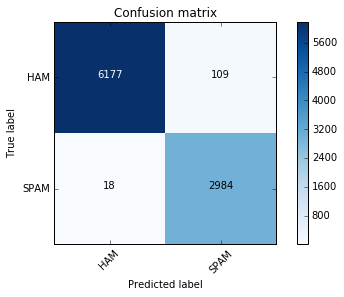

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

models = [
    (RandomForestClassifier(n_estimators=10), "Random Forest"),
#     (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(n_iter=50), "Perceptron"),
    (LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3), "L2 Reguralized SVM"),
    (LinearSVC(loss='squared_hinge', penalty='l1', dual=False, tol=1e-3), "L1 Reguralized SVM"),
    (SGDClassifier(alpha=.0001, n_iter=50, penalty='l2'), "L2 Reguralized SGD"),
    (SGDClassifier(alpha=.0001, n_iter=50, penalty='l1'), "L1 Reguralized SGD"),
    (SGDClassifier(alpha=.0001, n_iter=50, penalty='elasticnet'), "Elastic-Net Reguralized SGD"),
    (MultinomialNB(alpha=.01), "Multinomial Naive Bayes"),
    (BernoulliNB(alpha=.01), "Bernoulli Naive Bayes"),
    (Pipeline([
      ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
      ('classification', LinearSVC())
    ]), "Linear SVC Feature Selection + SVC")
]

results = []
for clf, name in models:
    print('=' * 80)
    print('***' + name + '***')
    results.append(benchmark(clf))


### Evaluation

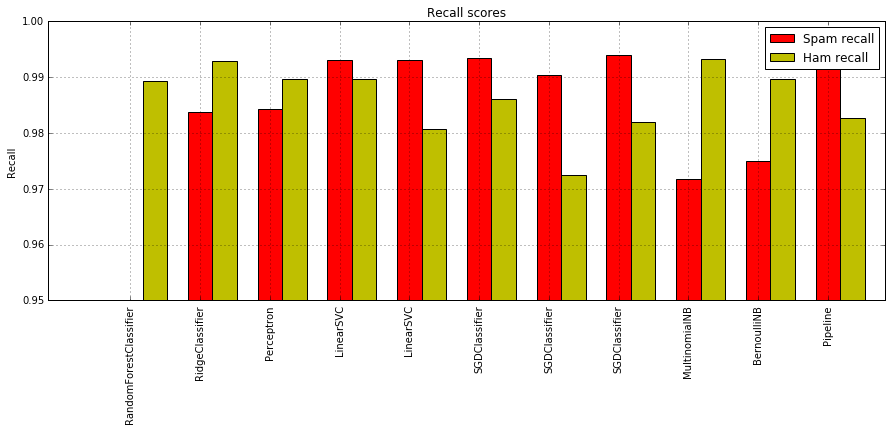

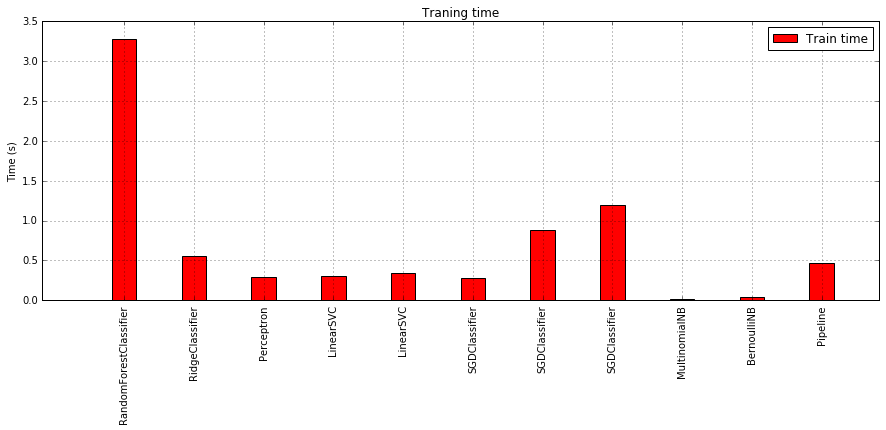

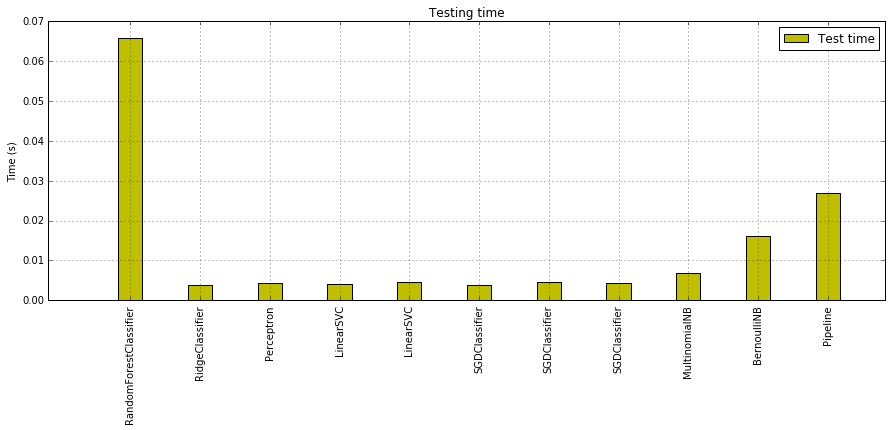

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

names = [r[0] for r in results]
spam_scores = [r[1][0] for r in results]
ham_scores = [r[1][1] for r in results]
train_times = [r[2] for r in results]
test_times = [r[3] for r in results]

ind = np.arange(1, len(results) + 1)  # the x locations for the groups
width = .35  # the width of the bars

plt.figure(figsize=(15,5))
plt.bar(ind, spam_scores, width, label='Spam recall', color='r')
plt.bar(ind + width, ham_scores, width, label='Ham recall', color='y')
plt.grid()
plt.title("Recall scores")
plt.ylim([0.95, 1])
plt.legend()
plt.ylabel("Recall")
plt.gca().set_xticks(ind + width / 2)
plt.gca().set_xticklabels(names, rotation=90)
plt.show()

plt.figure(figsize=(15,5))
plt.bar(ind, train_times, width, label='Train time', color='r')
plt.grid()
plt.title("Traning time")
plt.legend()
plt.ylabel("Time (s)")
plt.gca().set_xticks(ind + width / 2)
plt.gca().set_xticklabels(names, rotation=90)
plt.show()

plt.figure(figsize=(15,5))
plt.bar(ind, test_times, width, label='Test time', color='y')
plt.grid()
plt.title("Testing time")
plt.legend()
plt.ylabel("Time (s)")
plt.gca().set_xticks(ind + width / 2)
plt.gca().set_xticklabels(names, rotation=90)
plt.show()



### Modelling ideas

- Ensemble meta learners
- Build model based on email header
- Build model based on AdPredictor CTR
- Active learning on problem cases
- Model stacking



### Tuning options

- Parameters for every model to tune, e.g. with Bayesian Optimization (Spearmint) or smart guessing
- Different feature extraction methods (TF-IDF / TF / TF-Norm / N-grams)
- Different tokenizers
- Meta-feature extractions
- Modelling n-grams


### Discussion

- It works very well, even when grouping multiple inboxes. That is suspicious. Might be discerning factor hidden in spam messages.

- Does it even make sense to do personalized spam detection? Much cheaper to have a few models than one for every inbox.

- No feature selection at all. Might try InformationGain ranking as suggested in paper.

- Ordering of data ignored. Might be dangerous if problem can be interpolated. In article, time line is respected.

- Possible errors in imported spam dataset. Non-latin characters. More data cleaning necessary.

- Spam gathered separately from production emails

- No benchmark yet for meta-feature models.

- Also no benchmark for business rule logic.


### Performance

- Pipeline not yet tuned for memory performance. Expensive copying of data.
- Room for parallelization in email stream or batch processing.
